# Toy Experiments with Wasserstein-2 Min Max Generative Networks (25 g)

Implementation of the min-max Wasserstein-2 optimal transport map following the [Makkuva et.al.](https://arxiv.org/pdf/1908.10962.pdf) for 25 grid-located gaussians

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..") #хак, чтобы модули искались в ".."

import torch
torch.random.manual_seed(0xBADBEEF)
import torch.nn as nn

from src.tools import compute_l1_norm, energy_based_distance, ewma
from src import distributions_legacy as distributions
from src.point_transforms import LinearPointwiseTransform, CirclePointwiseTransform

from src.icnn import DenseICNN, LinDenseICNN

## Config

In [ ]:
OUTPUT = '25g' # or 8g, 25g, 49g, 100g, swiss
L1 = 1e-10
LAMBDA = 1.
GPU_DEVICE = 0
BATCH_SIZE = 1024
LR = 1e-3
DEVICE = 'cuda'

In [ ]:
# source distribution
Y_sampler = distributions.StandartNormalSampler(dim=2, requires_grad=True, device=DEVICE)

# target distribution
X_sampler = distributions.StandardNormalScaler(requires_grad=True, device=DEVICE) # Is used to scale the input distribution (это просто трансформ, пайторчовыми пользоваться не хотим)

if OUTPUT == '8g':
    X_sampler.fit(distributions.Mix8GaussiansSampler(device=DEVICE), batch_size=100000)
elif OUTPUT == '25g':
    X_sampler.fit(distributions.MixN2GaussiansSampler(n=5, device=DEVICE), batch_size=100000)
elif OUTPUT == '49g':
    X_sampler.fit(distributions.MixN2GaussiansSampler(n=7, device=DEVICE), batch_size=100000)
elif OUTPUT == '100g':
    X_sampler.fit(distributions.MixN2GaussiansSampler(n=10, device=DEVICE), batch_size=100000)
elif OUTPUT == 'swiss':
    X_sampler.fit(distributions.SwissRollSampler(device=DEVICE), batch_size=100000)
elif OUTPUT == '2l':
    X_sampler.fit(distributions.LineGaussiansSampler(2, l=3., std=0.1, device=DEVICE), batch_size=100000)
else:
    raise Exception('Unknown output distribution')

if DEVICE == 'cuda':
    torch.cuda.empty_cache()

## Discriminators Setup

In [ ]:
D = DenseICNN(
    2, rank=3, hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6, device=DEVICE
).to(device=DEVICE)

D_conj = DenseICNN(
    2, rank=3,
    hidden_layer_sizes=[128, 128, 64],
    dropout=1e-5, strong_convexity=1e-6, device = DEVICE
).to(device=DEVICE)

# D = LinDenseICNN(
#     2, hidden_layer_sizes=[64, 64, 64, 64], activation=nn.CELU(), device=DEVICE)

# D_conj = LinDenseICNN(
#     2, hidden_layer_sizes=[64, 64, 64, 64], activation=nn.CELU(), device=DEVICE)

# Manual weights init
for p in D.parameters():
    p.data = torch.randn(p.shape, device=DEVICE, dtype=torch.float32) / 2.

print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

27520 parameters in Discriminative Network


### Pretraining

In [ ]:
pre_D_opt = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.8, 0.9))

D.train(True)
loss = np.inf

for iteration in tqdm(range(10000)):
    X = (X_sampler.sample(BATCH_SIZE)).detach()
    X.requires_grad_(True)

    loss = ((D.push(X) - X) ** 2).sum(dim=1).mean() + L1 * compute_l1_norm(D)
    loss.backward()
    pre_D_opt.step()
    pre_D_opt.zero_grad()
    D.convexify() # не очень понятно, зачем он это здесь делает
    
    if iteration % 500 == 0:
        clear_output(wait=True)
        print('Pretraining the discriminator for D.push(x)=x')
        print('Current loss:', loss.item())
    
    if loss.item() < .3 * 1e-4:
        clear_output(wait=True)
        break
print('Final Loss:', loss.item())
D_conj.load_state_dict(D.state_dict())

Final Loss: 2.996297916979529e-05


<All keys matched successfully>

## Main training

In [ ]:
class LossCollector:

    def __init__(self, n_averaging):
        self.n_averaging = n_averaging
        self.collected = 0
        self.history = []
        self.current = 0.

    
    def add(self, value):
        if self.collected < self.n_averaging:
            if isinstance(value, torch.Tensor):
                value = value.item()
            self.current += value
            self.collected += 1

        if self.collected == self.n_averaging:
            self.history.append(self.current/self.n_averaging)
            self.reset_current()
    
    def reset_current(self):
        self.collected = 0
        self.current = 0.
    
    def reset(self):
        self.history = []
        self.reset_current()
    
    def get_history(self, inscribe_incomplete=False, incomplete_limit=1):
        history = self.history
        if inscribe_incomplete:
            assert(incomplete_limit >= 1)
            if self.collected >= incomplete_limit:
                history.append(self.current/self.collected)
        return history

In [ ]:
from torch.optim.lr_scheduler import StepLR
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.9))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.8, 0.9))
#sheduler = StepLR(D_opt, step_size=3000, gamma=0.3)

In [ ]:
w_loss_history = LossCollector(1)
j_loss_history = LossCollector(10)
j_f_loss_history = LossCollector(10)
j_scalar_loss_history = LossCollector(10)
w_x_loss_history = LossCollector(1)
w_gy_loss_history = LossCollector(1)
losses = [
    w_loss_history,
    j_loss_history,
    j_f_loss_history,
    j_scalar_loss_history,
    w_x_loss_history,
    w_gy_loss_history
]

QP_energy = []
l_xy_trf = LinearPointwiseTransform(5, phi=np.pi/4., space=0.25, device=DEVICE)
c_one_trf = CirclePointwiseTransform(7, device=DEVICE)


In [ ]:
plot_batchsize = 3000 if OUTPUT == '100g' else 1000
s = 10 if OUTPUT == '100g' else None
figsize = (16, 16) if OUTPUT == '100g' else (12, 12)
lim = 1.8 if OUTPUT == '100g' else 2.2

# plot_every = 2500 if (OUTPUT in ['49g', '100g']) else 1000
plot_every = 200
# max_iter = 100001 if (OUTPUT in ['49g', '100g']) else 30001
max_iter=10000
g_max_iter = 20
pos_wt_reg = 1.
reset_every = 200

energy_every = 20
energy_batchsize = 1024

Iteration 9800


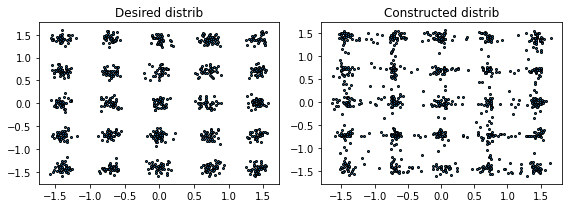

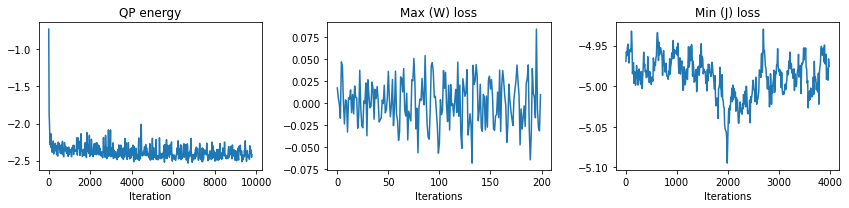

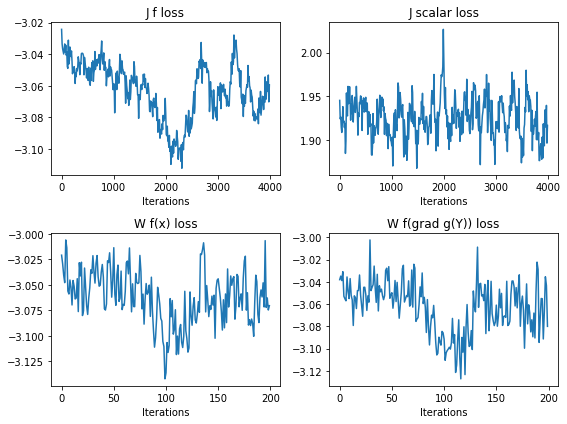

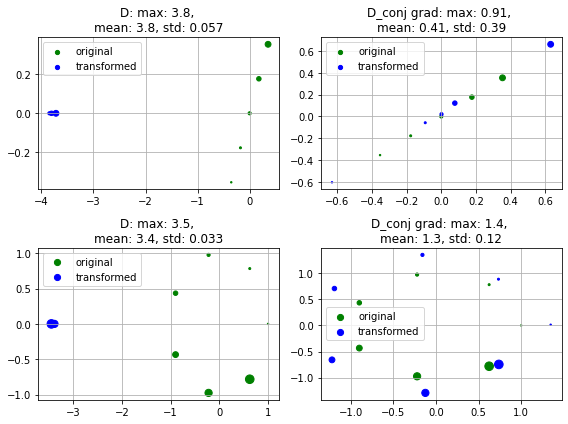

In [10]:
def plot_loss(loss, ax, title='Loss', xname='Iterations'):
    history = loss.get_history()
    ax.plot(
        range(0, loss.n_averaging * len(history), loss.n_averaging),
        history
    )
    ax.set_title(title)
    ax.set_xlabel(xname)

print('Fitting the monotone generative mapping')
# D_conj === g
# D === f
for iteration in range(max_iter):
    D.train(True); D_conj.train(True)

    for g_iteration in range(g_max_iter):

        D_opt.zero_grad()
        D_conj_opt.zero_grad()

        Y = Y_sampler.sample(BATCH_SIZE)
        b_size = Y.size(0)
        n_dim = Y.size(1)
        Y_inv = D_conj.push(Y)
        assert(list(Y_inv.shape) == [b_size, n_dim])
        j_f_loss_history.add(D(Y_inv).mean().item())
        j_scalar_loss_history.add((Y * Y_inv).view(b_size, n_dim).sum(-1).mean().item())
        J_loss = (D(Y_inv) - (Y * Y_inv).view(b_size, n_dim).sum(-1)).mean() #+ pos_wt_reg * D_conj.relaxed_convexity_regularization()
        j_loss_history.add(J_loss.item())
        J_loss.backward()
        D_conj_opt.step()
        D_opt.zero_grad(); D_conj_opt.zero_grad()
        D_conj.convexify()
    
    X = X_sampler.sample(BATCH_SIZE) # sample from target
    Y = Y_sampler.sample(BATCH_SIZE) # sample from source

    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()    
    W_loss = (D(X) - D(Y_inv)).mean()
    w_loss_history.add(W_loss.item())
    w_x_loss_history.add(D(X).mean().item())
    w_gy_loss_history.add(D(Y_inv).mean().item())
    W_loss.backward()
    D_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad()
    D.convexify()
    # sheduler.step()
    # D_conj.convexify()     
    
    if iteration % energy_every == 0:

        Y = Y_sampler.sample(energy_batchsize) # source batch
        X = X_sampler.sample(energy_batchsize) # target batch
        Y_inv = D_conj.push(Y).detach()
        with torch.no_grad():
            QP_energy.append(energy_based_distance(X, Y_inv, device=DEVICE).item())
            
    if iteration % plot_every == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        D.train(False); D_conj.train(False)

        # draw reconstruction and original distribuitions scatters
        fig, axes = plt.subplots(1, 2, figsize=(8, 3))
        Y = Y_sampler.sample(energy_batchsize)
        X_from_Y = D_conj.push(Y).detach().cpu().numpy()
        X = X_sampler.sample(energy_batchsize).detach().cpu().numpy()

        axes[0].scatter(X[:, 0], X[:, 1], edgecolors='black', s=4.)
        axes[0].set_title('Desired distrib')
        axes[1].scatter(X_from_Y[:, 0], X_from_Y[:, 1], edgecolors='black', s=4.)
        axes[1].set_title('Constructed distrib')
        fig.tight_layout()
        plt.show()
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))

        axes[0].plot(
            range(0, energy_every * len(QP_energy), energy_every),
            np.log10(np.abs(QP_energy))
        )
        axes[0].set_title('QP energy')
        axes[0].set_xlabel('Iteration')

        plot_loss(w_loss_history, axes[1], title='Max (W) loss')
        plot_loss(j_loss_history, axes[2], title='Min (J) loss')

        fig.tight_layout()
        plt.show()

        fig, axes = plt.subplots(2, 2, figsize=(8, 6))
        # w_loss_history,
        # j_loss_history,
        # j_f_loss_history,
        # j_scalar_loss_history,
        # w_x_loss_history,
        # w_gy_loss_history
        plot_loss(j_f_loss_history, axes[0, 0], title='J f loss')
        plot_loss(j_scalar_loss_history, axes[0, 1], title= "J scalar loss")
        plot_loss(w_x_loss_history, axes[1, 0], title='W f(x) loss')
        plot_loss(w_gy_loss_history, axes[1, 1], title='W f(grad g(Y)) loss')
        
        fig.tight_layout()
        plt.show()

        fig, axes = plt.subplots(2, 2, figsize=(8, 6))

        l_xy_trf.show_transform(D, axes[0, 0], title='D')
        l_xy_trf.show_transform(D_conj, axes[0, 1], title="D_conj grad", grad=True)
        c_one_trf.show_transform(D, axes[1, 0], title='D')
        c_one_trf.show_transform(D_conj, axes[1, 1], title="D_conj grad", grad=True)
        
        fig.tight_layout()
        plt.show()
    
    if iteration % reset_every == 0:
        for loss in losses:
            loss.reset()
